In [1]:
import pandas as pd
import numpy as np
import pyreadr
import torch
from torch import nn
from torch.optim import Adam
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

In [2]:
data = pd.read_csv("./Data/Aging_data_combined_orthologs.csv")
datawNAN = data[data['Tissue'] == "Brain"][data['Species'] == "Human"].fillna(0)
datawNAN = torch.Tensor(datawNAN.select_dtypes(include=['float64']).iloc[:, :-1].values)

/tmp/ipykernel_5776/2326441598.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  datawNAN = data[data['Tissue'] == "Brain"][data['Species'] == "Human"].fillna(0)


In [3]:
data[data['Tissue'] == "Brain"][data['Species'] == "Human"].shape

/tmp/ipykernel_5776/1414031641.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data[data['Tissue'] == "Brain"][data['Species'] == "Human"].shape


(1018, 15818)

In [4]:
batch_size = 64

data_size = datawNAN.shape[0]
validation_split = .2
test_split = .2
split_val = int(np.floor(validation_split * data_size))
split_test = int(np.floor(test_split * data_size))

indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices, test_indices = indices[split_val + split_test:], indices[:split_val], \
                                           indices[:split_val + split_test]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)


train_loader = torch.utils.data.DataLoader(datawNAN, batch_size=batch_size,
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(datawNAN, batch_size=batch_size,
                                          sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(datawNAN, batch_size=batch_size,
                                           sampler=test_sampler)

In [5]:
class VaeEncoder(nn.Module):
    def __init__(self, input_size: int, latent_size: int, down_channels: int):
        super().__init__()
        self._latent_size = latent_size
        self._input_size = input_size

        in_features = input_size
        x = (input_size // (2 * latent_size)) ** (1 / down_channels)

        #         print(x, input_size, 2*latent_size, 1/down_channels)

        modules = []
        for _ in range(down_channels - 1):
            out_features = int(in_features // x)
            modules += [
                torch.nn.Linear(in_features, out_features, bias=True),
                torch.nn.BatchNorm1d(out_features),
                torch.nn.LeakyReLU()
            ]
            in_features = out_features
        modules += [torch.nn.Linear(in_features, 2 * latent_size)]
        self._encoder = nn.Sequential(*modules)
        # print(self._encoder.parameters())

    def forward(self, vector):
        encoded = self._encoder(vector)
        assert encoded.shape[1] == self._latent_size * 2
        mu, log_sigma = torch.split(encoded, self._latent_size, dim=1)
        return mu, log_sigma


class VaeDecoder(nn.Module):
    def __init__(self, output_size: int, latent_size: int, up_channels: int):
        super().__init__()
        self._latent_size = latent_size
        self._output_size = output_size

        in_features = latent_size
        x = (output_size // (latent_size)) ** (1 / up_channels)

        #         print(x)
        modules = []

        for _ in range(up_channels - 1):
            out_features = int(in_features * x)
            modules += [
                torch.nn.Linear(in_features, out_features, bias=True),
                torch.nn.BatchNorm1d(out_features),
                torch.nn.LeakyReLU()
            ]
            in_features = out_features
        modules += [torch.nn.Linear(in_features, output_size)]
        self._decoder = nn.Sequential(*modules)

    def forward(self, embeddings):
#         embeddings = embeddings.reshape(*embeddings.shape, 1, 1)
        return self._decoder(embeddings)

In [6]:
class Age(nn.Module):
    def __init__(self, input_size: int):
        super().__init__()
        self._input_size = input_size

        self._model = torch.nn.Linear(input_size, 1, bias=True)
        self._relu = torch.nn.ReLU()
        self._norm = torch.nn.BatchNorm1d(1)
        # print(self._encoder.parameters())

    def forward(self, vector):
        return self._relu(self._norm(self._model(vector))).flatten()

In [7]:
class VAEAge(nn.Module):
    def __init__(self, input_size, latent_size=10, down_channels=2, up_channels=2):
        super().__init__()

        self._encoder = VaeEncoder(input_size, latent_size, down_channels)
        self._decoder = VaeDecoder(input_size, latent_size, up_channels)
        self._age = Age(latent_size)
        
    def forward(self, x):
        mu, log_sigma = self._encoder(x)
        sigma = torch.exp(log_sigma)

        kld = 0.5 * (sigma + torch.square(mu) - log_sigma - 1)

        z = mu + torch.randn_like(sigma) * sigma
        x_pred = self._decoder(z)
        age_pred = self._age(z)
        return x_pred, kld, age_pred

    def encode(self, x):
        mu, log_sigma = self._encoder(x)
        sigma = torch.exp(log_sigma)

        return mu + torch.randn_like(sigma) * sigma

    def decode(self, z):
        return self._decoder(z)


In [8]:
def train_vae(vae, dataloader, dataloader_val, dataset, batch_size):
    vae.cuda()

    epochs = 201
    vae_optim = Adam(vae.parameters(), lr=1e-4)

    #     test_imgs_1 = torch.cat([dataset[i].unsqueeze(0) for i in (0, 34, 76, 1509)])
    #     test_imgs_2 = torch.cat([dataset[i].unsqueeze(0) for i in (734, 123, 512, 3634)])

    for ep in range(epochs):
        total_batches = 0
        rec_loss_avg = 0
        kld_loss_avg = 0
        r2_avg = 0
        age_loss_avg = 0
        r2_age_avg = 0
        
        total_batches_val = 0
        rec_loss_avg_val = 0
        kld_loss_avg_val = 0
        r2_avg_val = 0
        age_loss_avg_val = 0
        r2_age_avg_val = 0
        
#                 if ep % 10 == 0:
#                     with torch.no_grad():
#                         indices = np.random.choice(dataset.shape[0], 10)
#                         z_1 = vae.encode(test_imgs_1.cuda())
#                         z_2 = vae.encode(test_imgs_2.cuda())
#                         x_int = []
#                         for i in range(9):
#                             z = (i * z_1 + (8 - i) * z_2) / 8
#                             x_int.append(vae.decode(z))
#                         x_int = torch.cat(x_int)
#                         visualise(x_int, rows=len(test_imgs_1))
#                         z_rand = torch.randn_like(z_1)
#                         x_int = vae.decode(z_rand)
#                         visualise(x_int, rows=len(test_imgs_1)//2)

        for i, batch in enumerate(dataloader):
            x, age = batch[:, :-1].cuda(), batch[:, -1].cuda()
            if len(batch) < batch_size:
                continue
            total_batches += 1
            x_rec, kld, age_pred = vae(x)
            img_elems = float(np.prod(list(batch.size())))
            kld_loss = kld.sum() / batch_size
            rec_loss = ((x_rec - x) ** 2).sum() / batch_size
            dis = ((x - torch.mean(x, dim = 0)) ** 2).sum() / batch_size
            r2 = 1 - rec_loss/dis
            dis_age = ((age - torch.mean(age, dim = 0)) ** 2).sum() / len(age)
            age_loss2 = ((age_pred - age) ** 2).sum() / len(age)
            age_loss = torch.sqrt(age_loss2)
            r2_age = 1 - age_loss2 / dis_age
            if i == 0:
                print("age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape", age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape)
                print("age_pred[0], age[0], batch_size, age_loss", age_pred[0], age[0], batch_size, age_loss)
            loss = rec_loss + 0.1 * kld_loss + 100 * age_loss # https://openreview.net/forum?id=Sy2fzU9gl
            vae_optim.zero_grad()
            loss.backward()
            vae_optim.step()
            kld_loss_avg += kld_loss.item()
            rec_loss_avg += rec_loss.item()
            age_loss_avg += age_loss.item()
            r2_age_avg += r2_age.item()
            r2_avg += r2.item()


        print(
            f"Epoch {ep + 1} | Age r2: {r2_age_avg / total_batches} | Age loss: {age_loss_avg / total_batches} | MSE loss: {rec_loss_avg / total_batches} | R2: {r2_avg / total_batches} | KLD loss: {kld_loss_avg / total_batches}")
        
        
        with torch.no_grad():
            for i, batch in enumerate(dataloader_val):
                x, age = batch[:, :-1].cuda(), batch[:, -1].cuda()
                if len(batch) < batch_size:
                    continue
                total_batches_val += 1
                x_rec, kld, age_pred = vae(x)
                kld_loss = kld.sum() / batch_size
                rec_loss = ((x_rec - x) ** 2).sum() / batch_size
                dis = ((x - torch.mean(x, dim = 0)) ** 2).sum() / batch_size
                dis_age = ((age - torch.mean(age, dim = 0)) ** 2).sum() / len(age)
                age_loss2 = ((age_pred - age) ** 2).sum() / len(age)
                age_loss = torch.sqrt(age_loss2)
                r2_age = 1 - age_loss2 / dis_age
                r2 = 1 - rec_loss/dis
                r2_avg_val += r2.item()
                kld_loss_avg_val += kld_loss.item()
                rec_loss_avg_val += rec_loss.item()
                age_loss_avg_val += age_loss.item()
                r2_age_avg_val += r2_age.item()

        print(
            f"Epoch {ep + 1} | Age r2: {r2_age_avg_val / total_batches_val} | Age loss val: {age_loss_avg_val / total_batches_val} | MSE loss val: {rec_loss_avg_val / total_batches_val} | R2 val: {r2_avg_val / total_batches_val} | KLD loss val: {kld_loss_avg_val / total_batches_val}")

input_size = datawNAN.shape[1] - 1
vae = VAEAge(input_size)
train_vae(vae, train_loader, val_loader, datawNAN, batch_size)

age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([64]) torch.Size([64]) torch.Size([64, 15812]) torch.Size([64, 15811]) torch.Size([64, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0., device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5984, device='cuda:0') 64 tensor(0.7127, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 1 | Age r2: -8.543119271596273 | Age loss: 0.6320388118426005 | MSE loss: 18100.09548611111 | R2: -6.49204953511556 | KLD loss: 4.676548931333754
Epoch 1 | Age r2: -5.936235268910726 | Age loss val: 0.5845260421435038 | MSE loss val: 16355.084309895834 | R2 val: -5.418428262074788 | KLD loss val: 5.651231447855632
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([64]) torch.Size([64]) torch.Size([64, 15812]) torch.Size([64, 15811]) torch.Size([64, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1181, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5568, device='cuda:0') 64 tensor(0.6836, devi

Epoch 13 | Age r2: -4.638149314456516 | Age loss: 0.48907940255271065 | MSE loss: 2557.0892469618057 | R2: -0.031666166252560086 | KLD loss: 37.188385009765625
Epoch 13 | Age r2: -3.5227606296539307 | Age loss val: 0.4754398663838704 | MSE loss val: 2820.19970703125 | R2 val: -0.13041017452875772 | KLD loss val: 37.18185297648112
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([64]) torch.Size([64]) torch.Size([64, 15812]) torch.Size([64, 15811]) torch.Size([64, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0., device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1911, device='cuda:0') 64 tensor(0.4007, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 14 | Age r2: -4.365223063362969 | Age loss: 0.4763973620202806 | MSE loss: 2385.694390190972 | R2: 0.033816383944617376 | KLD loss: 38.57232157389323
Epoch 14 | Age r2: -3.4533395767211914 | Age loss val: 0.47240949670473736 | MSE loss val: 2216.164306640625 | R2 val: 0.14664912223815918 | KLD loss val: 3

Epoch 25 | Age r2: -3.5143148634168835 | Age loss: 0.4408206774128808 | MSE loss: 1378.202385796441 | R2: 0.44223953617943657 | KLD loss: 41.28618367513021
Epoch 25 | Age r2: -2.4568562507629395 | Age loss val: 0.42088762919108075 | MSE loss val: 1629.7730305989583 | R2 val: 0.37337515751520794 | KLD loss val: 40.15651194254557
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([64]) torch.Size([64]) torch.Size([64, 15812]) torch.Size([64, 15811]) torch.Size([64, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0., device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.6898, device='cuda:0') 64 tensor(0.4197, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 26 | Age r2: -3.3622631231943765 | Age loss: 0.4275882409678565 | MSE loss: 1426.470458984375 | R2: 0.43356146415074664 | KLD loss: 40.863214280870224
Epoch 26 | Age r2: -2.5098151365915933 | Age loss val: 0.41700048247973126 | MSE loss val: 1391.5918782552083 | R2 val: 0.4657410979270935 | KLD loss val: 40

Epoch 37 | Age r2: -2.4977275795406766 | Age loss: 0.3828759226534102 | MSE loss: 1301.374016655816 | R2: 0.4356308513217502 | KLD loss: 40.630989498562286
Epoch 37 | Age r2: -1.5697282950083415 | Age loss val: 0.3614344497521718 | MSE loss val: 1309.4737548828125 | R2 val: 0.49593838055928546 | KLD loss val: 39.77248001098633
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([64]) torch.Size([64]) torch.Size([64, 15812]) torch.Size([64, 15811]) torch.Size([64, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0., device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2078, device='cuda:0') 64 tensor(0.3472, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 38 | Age r2: -2.452789730495877 | Age loss: 0.3784801397058699 | MSE loss: 1154.3243950737847 | R2: 0.5313864747683207 | KLD loss: 40.5651732550727
Epoch 38 | Age r2: -1.3225436210632324 | Age loss val: 0.34515032172203064 | MSE loss val: 1251.5731201171875 | R2 val: 0.5062255064646403 | KLD loss val: 39.756

Epoch 49 | Age r2: -2.1593806743621826 | Age loss: 0.3664017683929867 | MSE loss: 1169.1536865234375 | R2: 0.5230225258403354 | KLD loss: 37.54004330105252
Epoch 49 | Age r2: -1.1368274291356404 | Age loss val: 0.3246657947699229 | MSE loss val: 977.734375 | R2 val: 0.6109132369359335 | KLD loss val: 37.500231424967446
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([64]) torch.Size([64]) torch.Size([64, 15812]) torch.Size([64, 15811]) torch.Size([64, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.9911, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.7147, device='cuda:0') 64 tensor(0.4263, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 50 | Age r2: -1.9306906594170465 | Age loss: 0.3501146071487003 | MSE loss: 1083.4523179796006 | R2: 0.5551116201612685 | KLD loss: 37.79653888278537
Epoch 50 | Age r2: -1.330022891362508 | Age loss val: 0.33861394723256427 | MSE loss val: 1379.6567993164062 | R2 val: 0.471227506796519 | KLD loss val: 36.7223205

Epoch 61 | Age r2: -2.147851096259223 | Age loss: 0.3577854302194383 | MSE loss: 1016.5607231987847 | R2: 0.5893784364064535 | KLD loss: 36.782704247368706
Epoch 61 | Age r2: -1.288207729657491 | Age loss val: 0.32960543036460876 | MSE loss val: 1024.9797973632812 | R2 val: 0.597537100315094 | KLD loss val: 36.069470723470054
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([64]) torch.Size([64]) torch.Size([64, 15812]) torch.Size([64, 15811]) torch.Size([64, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.8627, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.7313, device='cuda:0') 64 tensor(0.2756, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 62 | Age r2: -1.411542296409607 | Age loss: 0.3168049222893185 | MSE loss: 867.2693277994791 | R2: 0.6368198063638475 | KLD loss: 37.500134785970054
Epoch 62 | Age r2: -0.9384727478027344 | Age loss val: 0.3072871466477712 | MSE loss val: 902.3189493815104 | R2 val: 0.6616910696029663 | KLD loss val: 37.0

Epoch 73 | Age r2: -1.1478361421161227 | Age loss: 0.30070924427774215 | MSE loss: 788.3853420681423 | R2: 0.6713091068797641 | KLD loss: 36.9968130323622
Epoch 73 | Age r2: -0.8551453351974487 | Age loss val: 0.30478550990422565 | MSE loss val: 834.78125 | R2 val: 0.6744772593180338 | KLD loss val: 36.02805201212565
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([64]) torch.Size([64]) torch.Size([64, 15812]) torch.Size([64, 15811]) torch.Size([64, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0., device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.4405, device='cuda:0') 64 tensor(0.2612, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 74 | Age r2: -0.8905649052725898 | Age loss: 0.28339531521002453 | MSE loss: 732.9905327690972 | R2: 0.6983266472816467 | KLD loss: 36.97659767998589
Epoch 74 | Age r2: -0.8645527760187784 | Age loss val: 0.30295059084892273 | MSE loss val: 875.1850382486979 | R2 val: 0.6536910533905029 | KLD loss val: 36.193969726562

Epoch 85 | Age r2: -0.8879255851109823 | Age loss: 0.2844686210155487 | MSE loss: 687.2126939561632 | R2: 0.722485707865821 | KLD loss: 35.404530419243706
Epoch 85 | Age r2: -0.6556088527043661 | Age loss val: 0.28509578108787537 | MSE loss val: 732.7649943033854 | R2 val: 0.7225000262260437 | KLD loss val: 35.07011286417643
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([64]) torch.Size([64]) torch.Size([64, 15812]) torch.Size([64, 15811]) torch.Size([64, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2901, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3158, device='cuda:0') 64 tensor(0.2368, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 86 | Age r2: -1.2540530496173434 | Age loss: 0.3018268843491872 | MSE loss: 743.0594007703993 | R2: 0.6855149467786154 | KLD loss: 36.02206590440538
Epoch 86 | Age r2: -0.6664778391520182 | Age loss val: 0.28789566953976947 | MSE loss val: 770.2279459635416 | R2 val: 0.6675411264101664 | KLD loss val: 36.3

Epoch 97 | Age r2: -1.016694770918952 | Age loss: 0.29537922971778446 | MSE loss: 674.1345147026909 | R2: 0.7170010805130005 | KLD loss: 35.25132497151693
Epoch 97 | Age r2: -0.5590332746505737 | Age loss val: 0.28318943579991657 | MSE loss val: 679.6822713216146 | R2 val: 0.7396864493687948 | KLD loss val: 34.4426523844401
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([64]) torch.Size([64]) torch.Size([64, 15812]) torch.Size([64, 15811]) torch.Size([64, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.5722, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3657, device='cuda:0') 64 tensor(0.3524, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 98 | Age r2: -1.086586594581604 | Age loss: 0.2900460809469223 | MSE loss: 667.9770439995659 | R2: 0.7141191098425124 | KLD loss: 35.39855490790473
Epoch 98 | Age r2: -0.4539698561032613 | Age loss val: 0.26966196795304614 | MSE loss val: 673.2992757161459 | R2 val: 0.7459636727968851 | KLD loss val: 34.530

Epoch 109 | Age r2: -0.6607205735312568 | Age loss: 0.26315688259071773 | MSE loss: 578.5103318956163 | R2: 0.7526428037219577 | KLD loss: 36.525453355577255
Epoch 109 | Age r2: -0.68925940990448 | Age loss val: 0.2863529473543167 | MSE loss val: 716.1628011067709 | R2 val: 0.7188308040301005 | KLD loss val: 35.80560811360677
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([64]) torch.Size([64]) torch.Size([64, 15812]) torch.Size([64, 15811]) torch.Size([64, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.7236, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5402, device='cuda:0') 64 tensor(0.2983, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 110 | Age r2: -0.8057834969626533 | Age loss: 0.27480343149767983 | MSE loss: 611.8630777994791 | R2: 0.7475095722410414 | KLD loss: 36.431888580322266
Epoch 110 | Age r2: -0.5981483459472656 | Age loss val: 0.281648521622022 | MSE loss val: 651.7852376302084 | R2 val: 0.7136470079421997 | KLD loss val: 3

Epoch 121 | Age r2: -0.6573212279213799 | Age loss: 0.2659091634882821 | MSE loss: 565.0864630805122 | R2: 0.7691715558369955 | KLD loss: 36.362658182779946
Epoch 121 | Age r2: -0.2778623104095459 | Age loss val: 0.2502362976471583 | MSE loss val: 614.5071207682291 | R2 val: 0.7620291113853455 | KLD loss val: 35.81317011515299
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([64]) torch.Size([64]) torch.Size([64, 15812]) torch.Size([64, 15811]) torch.Size([64, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.7405, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.6981, device='cuda:0') 64 tensor(0.2865, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 122 | Age r2: -0.9291705158021715 | Age loss: 0.27998397250970203 | MSE loss: 578.7007039388021 | R2: 0.7517706023322211 | KLD loss: 36.595015631781685
Epoch 122 | Age r2: -0.3185495138168335 | Age loss val: 0.2595017949740092 | MSE loss val: 612.7294311523438 | R2 val: 0.75725785891215 | KLD loss val: 3

Epoch 133 | Age r2: -0.49800439013375175 | Age loss: 0.2523120989402135 | MSE loss: 540.724622938368 | R2: 0.7696137693193223 | KLD loss: 36.28974829779731
Epoch 133 | Age r2: -0.3753675619761149 | Age loss val: 0.25784314175446826 | MSE loss val: 631.7325032552084 | R2 val: 0.756316085656484 | KLD loss val: 35.40557352701823
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([64]) torch.Size([64]) torch.Size([64, 15812]) torch.Size([64, 15811]) torch.Size([64, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0., device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1330, device='cuda:0') 64 tensor(0.2289, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 134 | Age r2: -0.4838240279091729 | Age loss: 0.2488609022564358 | MSE loss: 533.8662821451823 | R2: 0.7776980267630683 | KLD loss: 36.38746854994032
Epoch 134 | Age r2: -0.7161339918772379 | Age loss val: 0.2887415885925293 | MSE loss val: 621.3229573567709 | R2 val: 0.7620942989985148 | KLD loss val: 35.651

Epoch 145 | Age r2: -0.5939456224441528 | Age loss: 0.25949374172422623 | MSE loss: 565.4056871202257 | R2: 0.756216393576728 | KLD loss: 36.908917321099175
Epoch 145 | Age r2: -0.3124338785807292 | Age loss val: 0.2538064469893773 | MSE loss val: 573.9790242513021 | R2 val: 0.7830619414647421 | KLD loss val: 35.871542612711586
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([64]) torch.Size([64]) torch.Size([64, 15812]) torch.Size([64, 15811]) torch.Size([64, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.7737, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5901, device='cuda:0') 64 tensor(0.2208, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 146 | Age r2: -0.7115923828548856 | Age loss: 0.26096002095275456 | MSE loss: 531.8211364746094 | R2: 0.7742818064159818 | KLD loss: 36.58187823825412
Epoch 146 | Age r2: -0.19635228315989176 | Age loss val: 0.24480676154295603 | MSE loss val: 554.4328206380209 | R2 val: 0.7904281417528788 | KLD loss va

Epoch 157 | Age r2: -0.3124125003814697 | Age loss: 0.23352159559726715 | MSE loss: 504.02077229817706 | R2: 0.7925734122594198 | KLD loss: 37.11981964111328
Epoch 157 | Age r2: -0.14110124111175537 | Age loss val: 0.23597557842731476 | MSE loss val: 517.3527628580729 | R2 val: 0.7975985606511434 | KLD loss val: 36.6196034749349
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([64]) torch.Size([64]) torch.Size([64, 15812]) torch.Size([64, 15811]) torch.Size([64, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.8313, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.7563, device='cuda:0') 64 tensor(0.2174, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 158 | Age r2: -0.3942827516131931 | Age loss: 0.24054054915905 | MSE loss: 483.7189127604167 | R2: 0.8023041685422262 | KLD loss: 37.371282789442276
Epoch 158 | Age r2: -0.17698204517364502 | Age loss val: 0.24325100580851236 | MSE loss val: 536.7044067382812 | R2 val: 0.795038123925527 | KLD loss val:

Epoch 169 | Age r2: -0.3701178762647841 | Age loss: 0.23823369046052298 | MSE loss: 498.78675333658856 | R2: 0.7853812045521207 | KLD loss: 37.38911777072482
Epoch 169 | Age r2: -0.16913028558095297 | Age loss val: 0.24282270669937134 | MSE loss val: 518.83837890625 | R2 val: 0.8009236454963684 | KLD loss val: 35.97319539388021
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([64]) torch.Size([64]) torch.Size([64, 15812]) torch.Size([64, 15811]) torch.Size([64, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.5582, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3989, device='cuda:0') 64 tensor(0.2373, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 170 | Age r2: -0.3055138720406426 | Age loss: 0.2322943773534563 | MSE loss: 473.6593085394965 | R2: 0.8068452609909905 | KLD loss: 36.840643141004776
Epoch 170 | Age r2: -0.1848973830540975 | Age loss val: 0.24245002369085947 | MSE loss val: 544.2591044108073 | R2 val: 0.7917434771855673 | KLD loss val

Epoch 181 | Age r2: -0.41232484579086304 | Age loss: 0.24185438619719613 | MSE loss: 512.1231486002604 | R2: 0.786983417140113 | KLD loss: 36.768948025173614
Epoch 181 | Age r2: -0.3751632173856099 | Age loss val: 0.26148677865664166 | MSE loss val: 607.9482625325521 | R2 val: 0.765911877155304 | KLD loss val: 35.50114949544271
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([64]) torch.Size([64]) torch.Size([64, 15812]) torch.Size([64, 15811]) torch.Size([64, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.5722, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.6233, device='cuda:0') 64 tensor(0.2413, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 182 | Age r2: -0.31388113896052044 | Age loss: 0.23626086281405556 | MSE loss: 472.77493964301215 | R2: 0.8071586224767897 | KLD loss: 36.5617684258355
Epoch 182 | Age r2: -0.17789248625437418 | Age loss val: 0.24510573347409567 | MSE loss val: 561.7379659016927 | R2 val: 0.7834512790044149 | KLD loss v

Epoch 193 | Age r2: -0.3090681831041972 | Age loss: 0.23339114752080706 | MSE loss: 442.4403483072917 | R2: 0.8187536862161424 | KLD loss: 37.07247755262587
Epoch 193 | Age r2: -0.24648372332255045 | Age loss val: 0.24323969086011252 | MSE loss val: 531.1504720052084 | R2 val: 0.7888688643773397 | KLD loss val: 36.288917541503906
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([64]) torch.Size([64]) torch.Size([64, 15812]) torch.Size([64, 15811]) torch.Size([64, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4852, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3324, device='cuda:0') 64 tensor(0.2917, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 194 | Age r2: -0.5435679290029738 | Age loss: 0.246663812134001 | MSE loss: 477.3689541286892 | R2: 0.7954504357443916 | KLD loss: 37.1585824754503
Epoch 194 | Age r2: -0.14697478214899698 | Age loss val: 0.23920476933320364 | MSE loss val: 530.3422139485677 | R2 val: 0.7915926178296407 | KLD loss val

In [37]:
X_embedded = TSNE(n_components=2, init='random').fit_transform(datawNAN[:, :-1].numpy())

In [40]:
d = {'t-SNE1': X_embedded[:, 0], 't-SNE2': X_embedded[:, 1], 'Age': data[data['Tissue'] == "Brain"][data['Species'] == "Human"]["Age_rel_m"]}
df = pd.DataFrame(data=d)

/tmp/ipykernel_7094/3965715868.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  d = {'t-SNE1': X_embedded[:, 0], 't-SNE2': X_embedded[:, 1], 'Age': data[data['Tissue'] == "Brain"][data['Species'] == "Human"]["Age_rel_m"]}


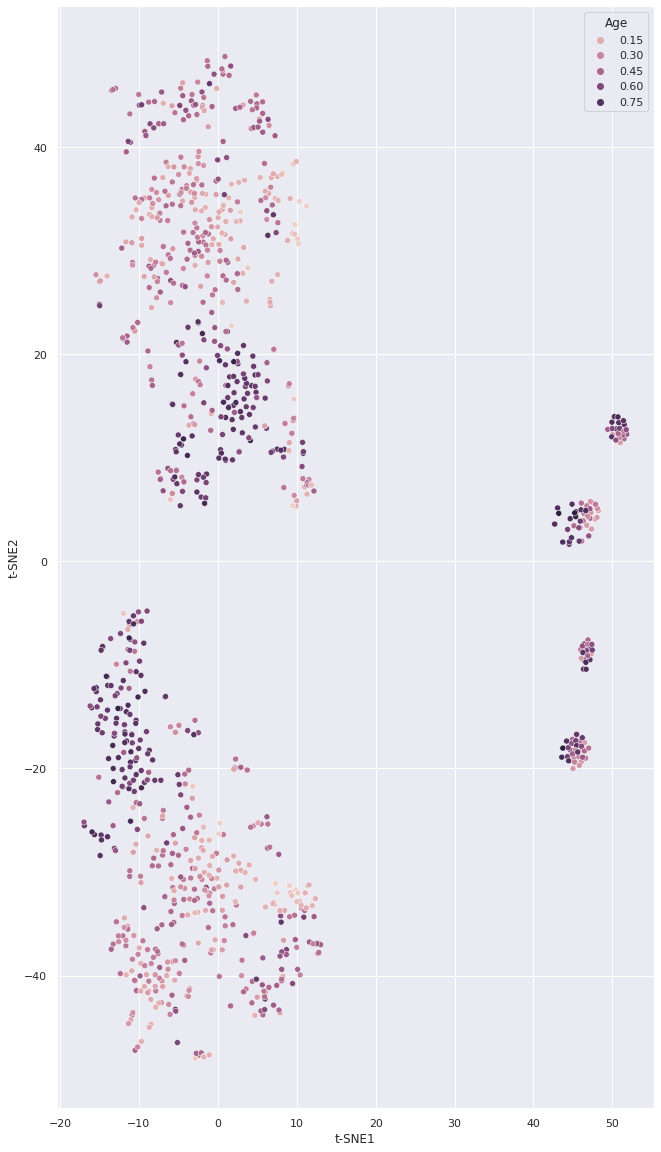

In [42]:
sns.scatterplot(data=df, x="t-SNE1", y="t-SNE2", hue="Age")
sns.set(rc={'figure.figsize':(5.7,10.27)})

In [43]:
x = vae.encode(datawNAN[:, :-1].cuda())
x.shape

torch.Size([1018, 10])

In [44]:
_, _, age = vae.forward(datawNAN[:, :-1].cuda())
print([x for x in vae._age._model.parameters()])

[Parameter containing:
tensor([[-0.1628,  0.1499,  0.2651,  0.0772,  0.0050, -0.0739,  0.1387,  0.0148,
          0.2456, -0.0391]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([0.2893], device='cuda:0', requires_grad=True)]


In [45]:
max(age), min(age)

(tensor(0.9405, device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor(0., device='cuda:0', grad_fn=<UnbindBackward0>))

In [47]:
vae_embedded = TSNE(n_components=2, init='random').fit_transform(x.cpu().detach().numpy())

In [48]:
d_vae = {'t-SNE1': vae_embedded[:, 0], 't-SNE2': vae_embedded[:, 1], 'Age': data[data['Tissue'] == "Brain"][data['Species'] == "Human"]["Age_rel_m"]}
df_vae = pd.DataFrame(data=d_vae)

/tmp/ipykernel_7094/2992101949.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  d_vae = {'t-SNE1': vae_embedded[:, 0], 't-SNE2': vae_embedded[:, 1], 'Age': data[data['Tissue'] == "Brain"][data['Species'] == "Human"]["Age_rel_m"]}


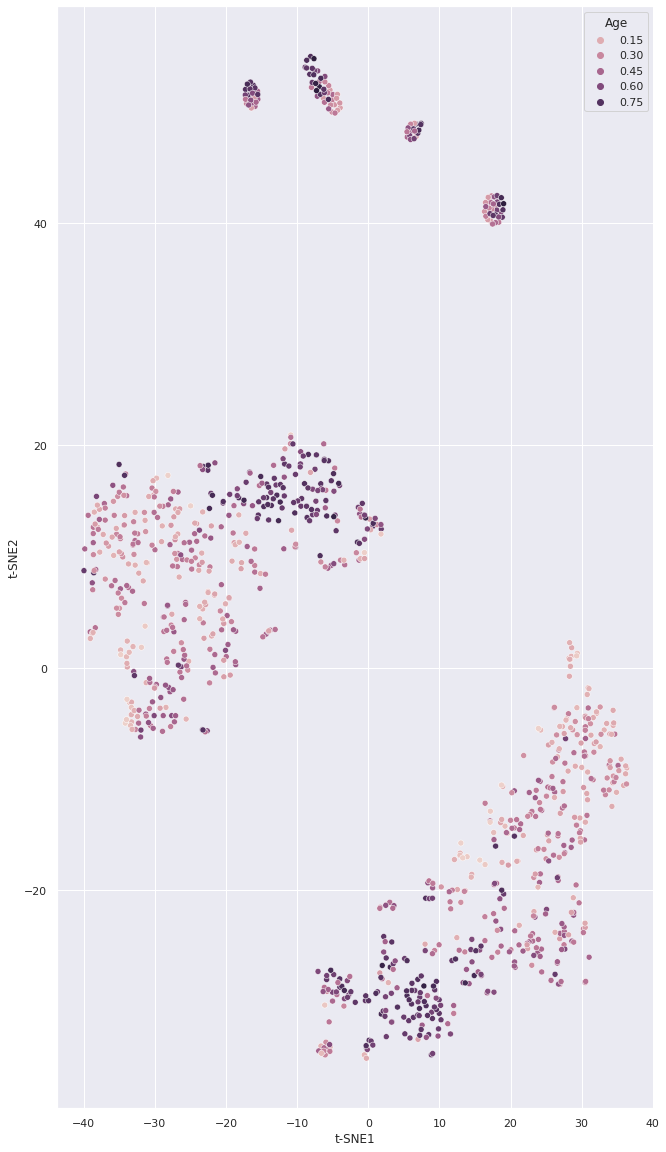

In [50]:
sns.scatterplot(data=df_vae, x="t-SNE1", y="t-SNE2", hue="Age")
sns.set(rc={'figure.figsize':(5.7,10.27)})

/tmp/ipykernel_7094/4196807225.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  vae1 = {'VAE1': x.cpu().detach()[:, 0], 'VAE2': x.cpu().detach()[:, 2], 'Age': data[data['Tissue'] == "Brain"][data['Species'] == "Human"]["Age_rel_m"]}


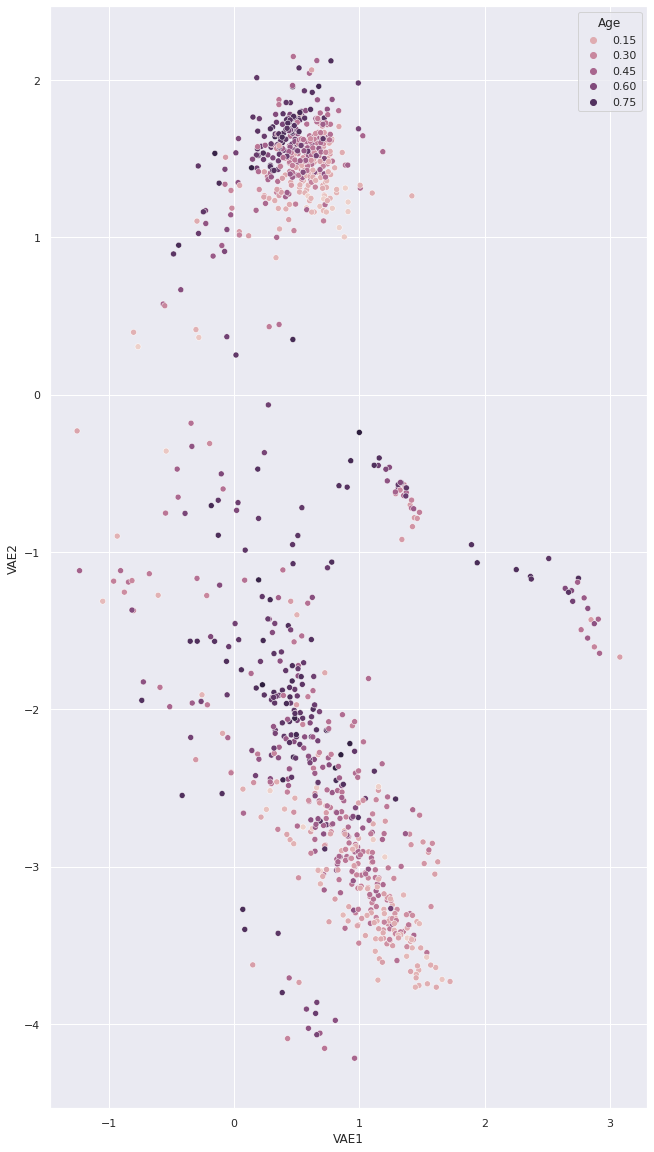

In [55]:
vae1 = {'VAE1': x.cpu().detach()[:, 0], 'VAE2': x.cpu().detach()[:, 2], 'Age': data[data['Tissue'] == "Brain"][data['Species'] == "Human"]["Age_rel_m"]}
df_vae1 = pd.DataFrame(data=vae1)
sns.scatterplot(data=df_vae1, x="VAE1", y="VAE2", hue="Age")
sns.set(rc={'figure.figsize':(10.7,10.27)})

/tmp/ipykernel_7094/3640960596.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  vae1 = {'VAE1': x.cpu().detach()[:, 2], 'VAE2': x.cpu().detach()[:, 8], 'Age': data[data['Tissue'] == "Brain"][data['Species'] == "Human"]["Age_rel_m"]}


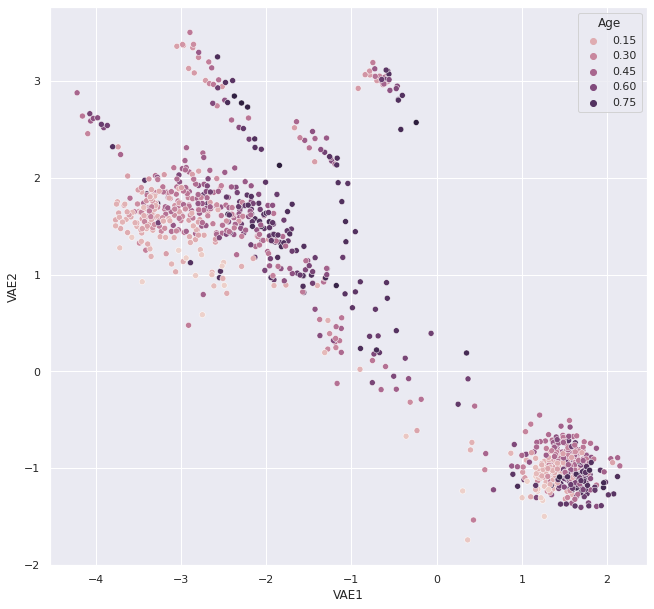

In [56]:
vae1 = {'VAE1': x.cpu().detach()[:, 2], 'VAE2': x.cpu().detach()[:, 8], 'Age': data[data['Tissue'] == "Brain"][data['Species'] == "Human"]["Age_rel_m"]}
df_vae1 = pd.DataFrame(data=vae1)
sns.scatterplot(data=df_vae1, x="VAE1", y="VAE2", hue="Age")
sns.set(rc={'figure.figsize':(10.7,10.27)})

/tmp/ipykernel_7094/563151024.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  vae1 = {'VAE1': x.cpu().detach()[:, 0], 'VAE2': x.cpu().detach()[:, 8], 'Age': data[data['Tissue'] == "Brain"][data['Species'] == "Human"]["Age_rel_m"]}


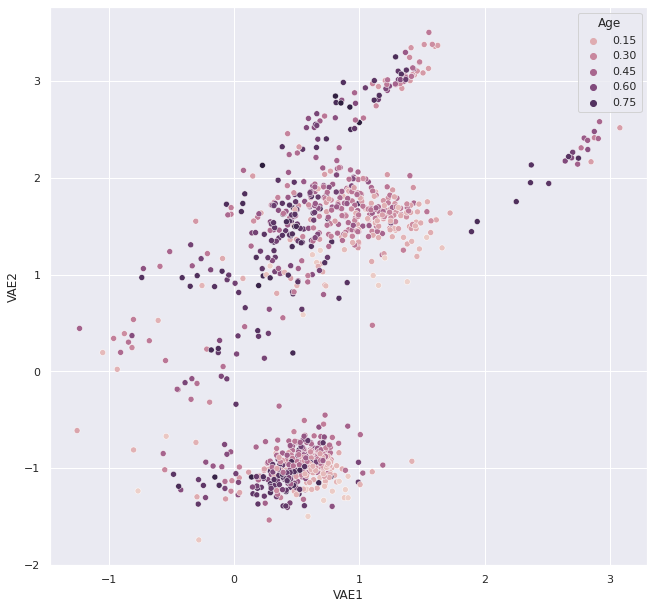

In [57]:
vae1 = {'VAE1': x.cpu().detach()[:, 0], 'VAE2': x.cpu().detach()[:, 8], 'Age': data[data['Tissue'] == "Brain"][data['Species'] == "Human"]["Age_rel_m"]}
df_vae1 = pd.DataFrame(data=vae1)
sns.scatterplot(data=df_vae1, x="VAE1", y="VAE2", hue="Age")
sns.set(rc={'figure.figsize':(10.7,10.27)})

/tmp/ipykernel_7094/656843756.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax.scatter(xs = x.cpu().detach()[:, 0], ys = x.cpu().detach()[:, 2], zs = x.cpu().detach()[:, 8], c = data[data['Tissue'] == "Brain"][data['Species'] == "Human"]["Age_rel_m"])


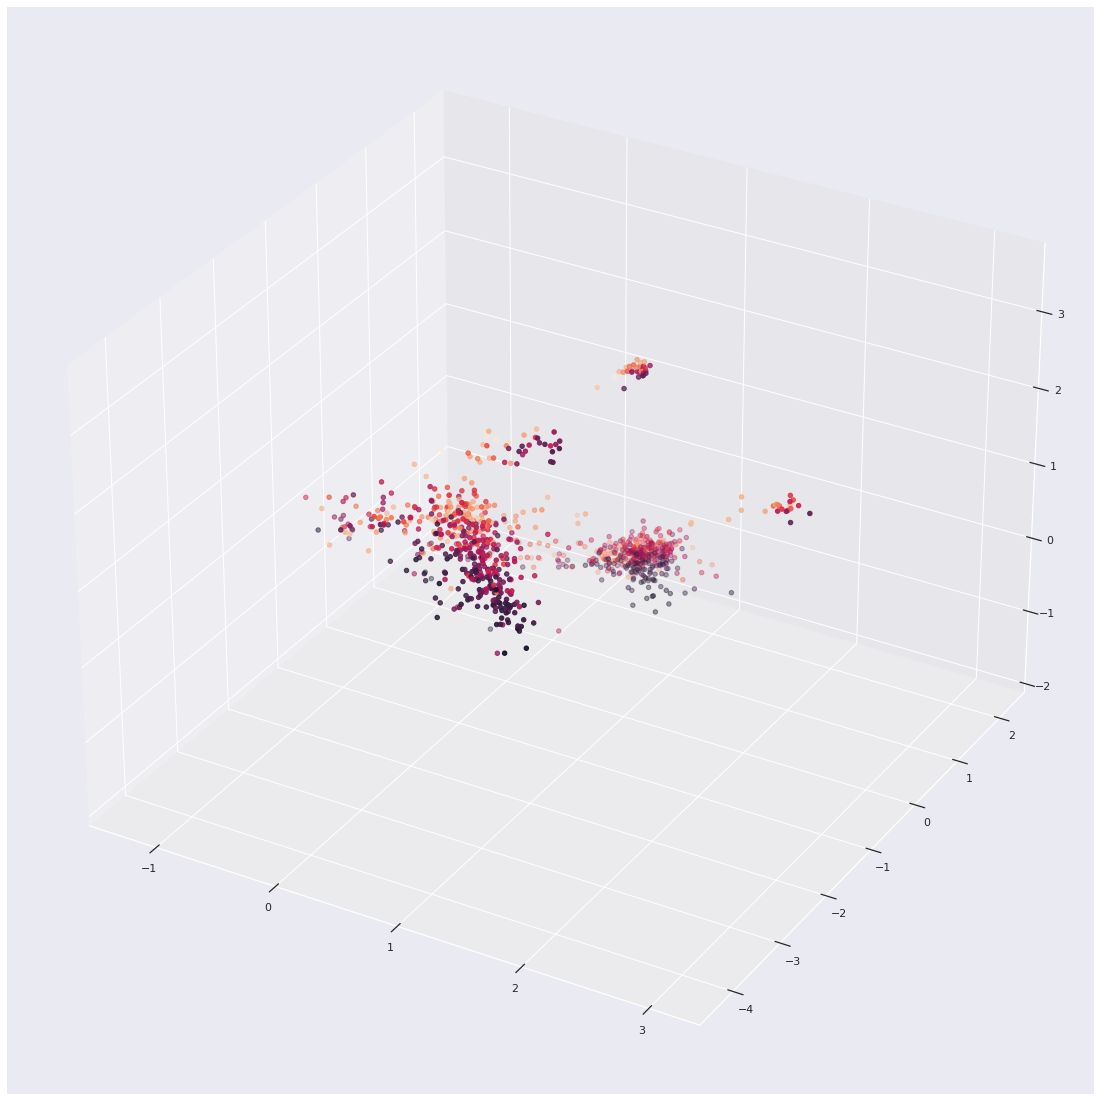

In [59]:
fig = plt.figure(figsize = [20, 20])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs = x.cpu().detach()[:, 0], ys = x.cpu().detach()[:, 2], zs = x.cpu().detach()[:, 8], c = data[data['Tissue'] == "Brain"][data['Species'] == "Human"]["Age_rel_m"])

In [79]:
corr = np.concatenate([x.cpu().detach().numpy(), np.array(data[data['Tissue'] == "Brain"][data['Species'] == "Human"]["Age_rel_m"]).reshape((-1, 1))], axis = 1)
corr.shape

/tmp/ipykernel_7094/2710287468.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  corr = np.concatenate([x.cpu().detach().numpy(), np.array(data[data['Tissue'] == "Brain"][data['Species'] == "Human"]["Age_rel_m"]).reshape((-1, 1))], axis = 1)


(1018, 11)

In [86]:
corrcoef = np.corrcoef(corr, rowvar = False)
corrcoef.shape

(11, 11)

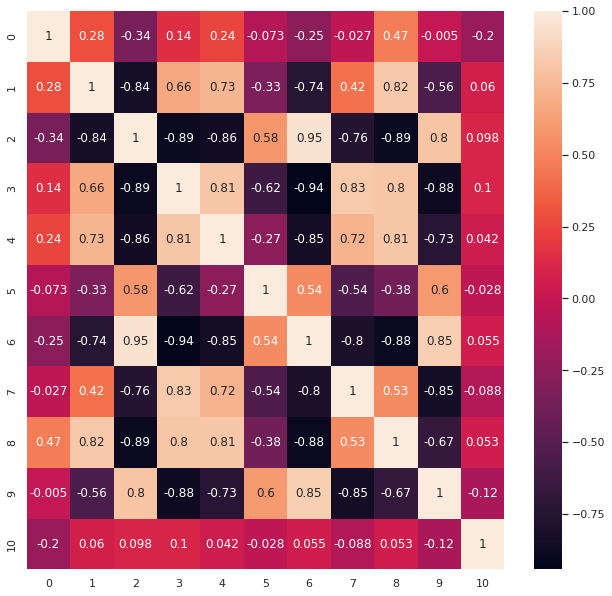

In [88]:
ax = sns.heatmap(corrcoef, annot=True)